In [1]:
import numpy
import tqdm
import scipy
import scipy.stats
import matplotlib
import matplotlib.pyplot
from joblib import dump, load
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from dirichlet_python.dirichletcal.calib.fulldirichlet import FullDirichletCalibrator
%matplotlib inline
font = {'weight' : 'bold',
        'size'   : 16}
matplotlib.rc('font', **font)

In [2]:
# specify the dataset settings (a mixutre of gaussian)

pi = numpy.array([0.5, 0.5])
ita_0 = numpy.array([0.5, 0.5])
ita_1 = numpy.array([0.5, 0.5])
mu_0_0 = numpy.array([4.0]) 
mu_0_1 = numpy.array([-64.0]) 
mu_1_0 = numpy.array([-4.0])
mu_1_1 = numpy.array([72.0 ]) 
cov_0_0 = numpy.array([960.0])
cov_0_1 = numpy.array([1280.0])
cov_1_0 = numpy.array([980.0])
cov_1_1 = numpy.array([1024.0])

In [3]:
# generate the feature and label samples

N = 10000
y = scipy.stats.multinomial.rvs(p=numpy.hstack([pi[0]*ita_0, pi[1]*ita_1]), size=N, n=1)
x = [scipy.stats.multivariate_normal.rvs(mean=mu_0_0, cov=cov_0_0, size=N).reshape(-1, 1),
     scipy.stats.multivariate_normal.rvs(mean=mu_0_1, cov=cov_0_1, size=N).reshape(-1, 1),
     scipy.stats.multivariate_normal.rvs(mean=mu_1_0, cov=cov_1_0, size=N).reshape(-1, 1),
     scipy.stats.multivariate_normal.rvs(mean=mu_1_1, cov=cov_1_1, size=N).reshape(-1, 1)]

x = x[0] * y[:, 0].reshape(-1, 1) + x[1] * y[:, 1].reshape(-1, 1) + \
    x[2] * y[:, 2].reshape(-1, 1) + x[3] * y[:, 3].reshape(-1, 1)

y = numpy.vstack([y[:, 0] + y[:, 1],
                  y[:, 2] + y[:, 3]]).transpose()

In [4]:
# train a NN classifier 
mdl = SVC()
mdl.fit(x, 1 - numpy.argmax(y,axis=1))

SVC()

In [5]:
# get predicted scores on samples
s = mdl.decision_function(x)

In [6]:
# get predicted scores on an interval
N_grid = 64
edge = 160.0
v_edge = 160.0
x_mesh = numpy.linspace(-edge, edge, N_grid).reshape(-1, 1)
s_mesh = mdl.decision_function(x_mesh)

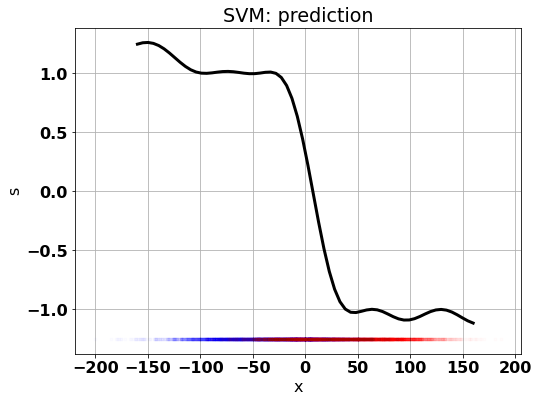

In [7]:
matplotlib.pyplot.figure(figsize=(8.0, 6.0))
matplotlib.pyplot.plot(x_mesh, s_mesh, 'k', linewidth=3.0)
matplotlib.pyplot.plot(x[y[:, 0]==1], numpy.zeros(numpy.sum(y[:, 0]==1)) - 1.25, 'bo', markersize=3, alpha=0.01)
matplotlib.pyplot.plot(x[y[:, 0]==0], numpy.zeros(numpy.sum(y[:, 0]==0)) - 1.25, 'ro', markersize=3, alpha=0.01)
# matplotlib.pyplot.ylim([0, 1])
matplotlib.pyplot.xlabel('x')
matplotlib.pyplot.ylabel('s')
matplotlib.pyplot.title('SVM: prediction')
# matplotlib.pyplot.ylim([-0.05, 1.05])
matplotlib.pyplot.grid()

In [8]:
cal = LogisticRegression()
cal.fit(mdl.decision_function(x).reshape(-1, 1), 1 - numpy.argmax(y,axis=1))

LogisticRegression()

In [9]:
s_hat = cal.predict_proba(s_mesh.reshape(-1, 1))

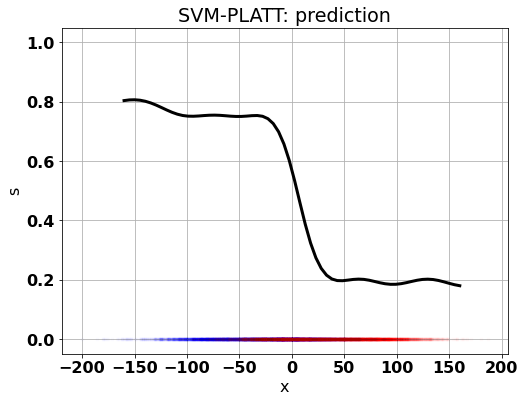

In [10]:
matplotlib.pyplot.figure(figsize=(8.0, 6.0))
matplotlib.pyplot.plot(x_mesh, s_hat[:, 1], 'k', linewidth=3.0)
matplotlib.pyplot.plot(x[y[:, 0]==1], numpy.zeros(numpy.sum(y[:, 0]==1)), 'bo', markersize=3, alpha=0.01)
matplotlib.pyplot.plot(x[y[:, 0]==0], numpy.zeros(numpy.sum(y[:, 0]==0)), 'ro', markersize=3, alpha=0.01)
# matplotlib.pyplot.ylim([0, 1])
matplotlib.pyplot.xlabel('x')
matplotlib.pyplot.ylabel('s')
matplotlib.pyplot.title('SVM-PLATT: prediction')
matplotlib.pyplot.ylim([-0.05, 1.05])
matplotlib.pyplot.grid()